In [2]:
import os
import torch
import cv2  # OpenCV
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

In [10]:
# --- 1. モデルのロード ---
sam_checkpoint = "sam_vit_b_01ec64.pth" # 軽量モデル
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

# ★ sam_model_registry は import されている必要があります
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# ★ SamAutomaticMaskGenerator は import されている必要があります
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    min_mask_region_area=200 
)

print("SAM model loaded successfully.")

Using device: cpu
SAM model loaded successfully.


In [11]:
# --- 2. 描画用のヘルパー関数 ---
def plot_images(stone_list, base_image, window_title_prefix):
    """
    石のリストとベース画像を受け取り、2枚の画像（輪郭・ID）を描画する
    """
    
    # ★ plt と cv2 は import されている必要があります
    
    # --- 1枚目: 輪郭のみ ---
    output_image_contours = base_image.copy()
    for stone in stone_list:
        # ★ np は import されている必要があります
        mask_uint8 = (stone['mask_data']['segmentation'] * 255).astype(np.uint8)
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(output_image_contours, contours, -1, (255, 0, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(output_image_contours)
    plt.title(f"{window_title_prefix} - Contours: {len(stone_list)} items")
    plt.axis('off')
    
    # --- 2枚目: ID表示付き ---
    output_image_with_ids = base_image.copy()
    
    # 輪郭を描画
    for stone in stone_list:
        mask_uint8 = (stone['mask_data']['segmentation'] * 255).astype(np.uint8)
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(output_image_with_ids, contours, -1, (255, 0, 0), 2)

    # IDを書き込む
    for stone in stone_list:
        x, y, w, h = stone['bbox']
        center_x = x + w // 2
        center_y = y + h // 2
        text = str(stone['id'])
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1
        text_color = (0, 255, 255) # 黄色
        
        (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, font_thickness)
        text_x = center_x - text_width // 2
        text_y = center_y + text_height // 2
        
        cv2.putText(output_image_with_ids, text, (text_x, text_y), font, font_scale, text_color, font_thickness, cv2.LINE_AA)

    plt.figure(figsize=(10, 10))
    plt.imshow(output_image_with_ids)
    plt.title(f"{window_title_prefix} - IDs: {len(stone_list)} items")
    plt.axis('off')
    
    # 2枚の画像を表示
    plt.show()

print("Helper function 'plot_images' defined.")

Helper function 'plot_images' defined.


画像を読み込んでいます: images/pyramid1_test.png
リサイズ後のサイズ: 1024x1024
SAMによる自動マスク生成を開始します...
完了しました。92個のオブジェクトが検出されました。

--- デバッグ前の初期画像 ---
ID付きの画像ウィンドウを参照してください。


/Users/yamadataro/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamadataro/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12496 (\N{KATAKANA LETTER BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamadataro/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamadataro/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12464 (\N{KATAKANA LETTER GU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamadataro/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2

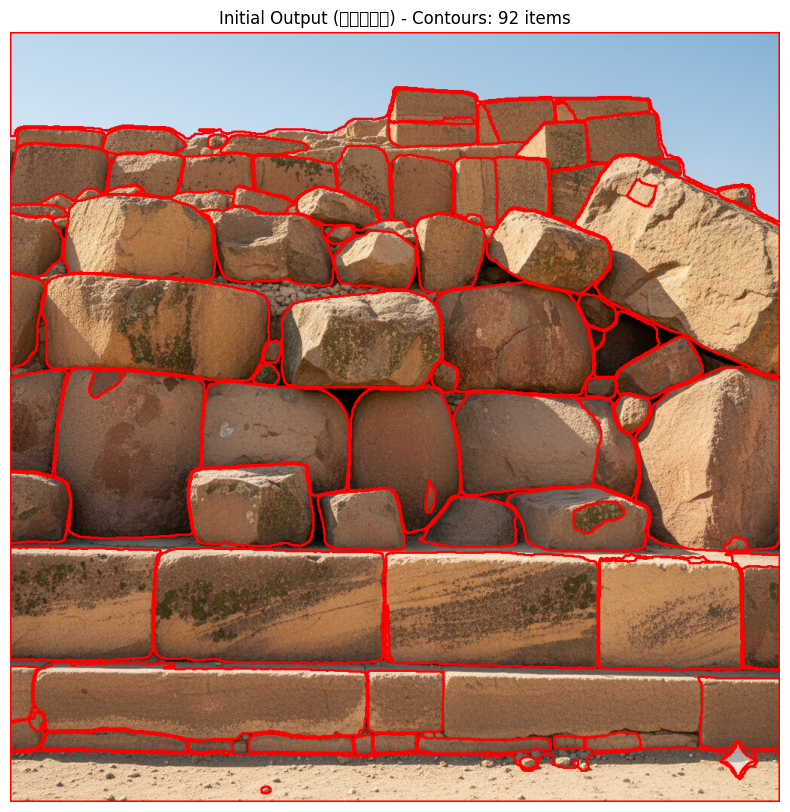

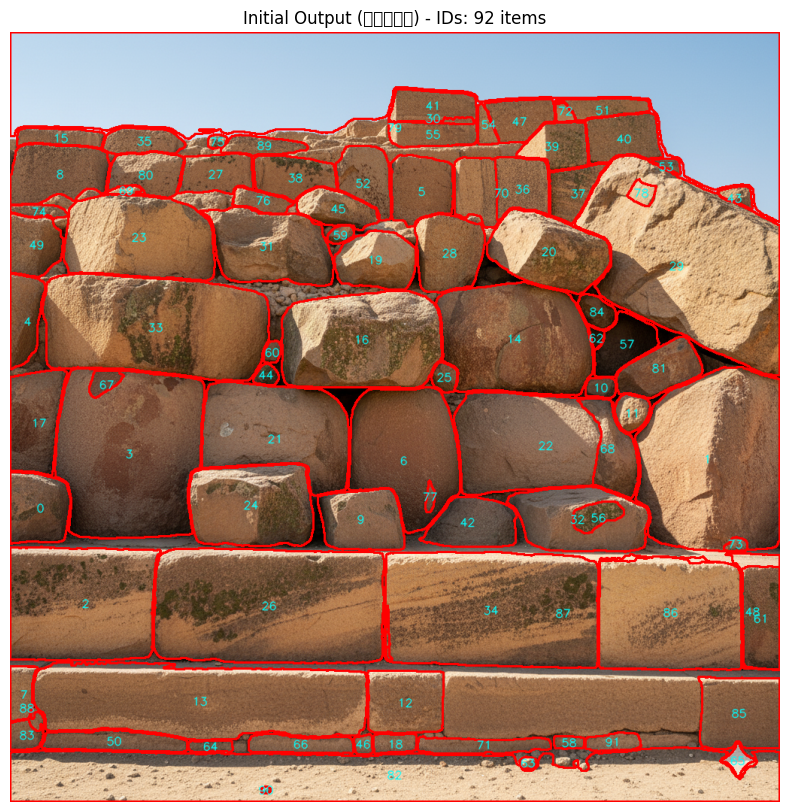


初期リストを作成しました。次のセルでデバッグを開始できます。


In [ ]:
# --- 3. メインの実行関数 (SAMの実行と初期リスト作成) ---

# (このセルで使うグローバル変数を初期化)
stone_candidates = []
image_rgb_processed = None # リサイズ後の画像を保持する変数

def run_segmentation_and_create_list(image_path):
    """
    SAMを実行し、石の候補リストと処理済み画像をグローバル変数に保存する。
    """
    # グローバル変数をこの関数内で更新することを明示
    global stone_candidates, image_rgb_processed
    
    # ★ np, cv2, os は import されている必要があります
    
    # --- 3-1. SAMの実行 ---
    print(f"画像を読み込んでいます: {image_path}")
    image_bytes = np.fromfile(image_path, dtype=np.uint8)
    image_bgr = cv2.imdecode(image_bytes, cv2.IMREAD_COLOR)
    
    if image_bgr is None:
        print(f"エラー: 画像ファイルが読み込めません: {image_path}")
        return
    
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # リサイズ
    max_size = 1024
    height, width = image_rgb.shape[:2]
    if height > max_size or width > max_size:
        scale = max_size / max(height, width)
        new_width = int(width * scale)
        new_height = int(height * scale)
        image_rgb_processed = cv2.resize(image_rgb, (new_width, new_height))
    else:
        image_rgb_processed = image_rgb.copy()
        
    print(f"リサイズ後のサイズ: {image_rgb_processed.shape[1]}x{image_rgb_processed.shape[0]}")

    print("SAMによる自動マスク生成を開始します...")
    # (mask_generator はグローバルスコープで定義済みと仮定)
    outputs = mask_generator.generate(image_rgb_processed)
    
    # stone_candidates をリセット
    stone_candidates = []
    for i, mask_data in enumerate(outputs):
        stone_candidates.append({
            "id": i,
            "area": float(np.sum(mask_data['segmentation'])),
            "bbox": mask_data['bbox'],
            "mask_data": mask_data
        })
    print(f"完了しました。{len(stone_candidates)}個のオブジェクトが検出されました。")

    # --- 3-2. デバッグ前の画像を表示 ---
    if not stone_candidates:
        print("オブジェクトが検出されませんでした。")
        return

    print("\n--- デバッグ前の初期画像 ---")
    print("ID付きの画像ウィンドウを参照してください。")
    # (plot_images はグローバルスコープで定義済みと仮定)
    plot_images(stone_candidates, image_rgb_processed, "Initial Output (デバッグ前)")
    
    print("\n初期リストを作成しました。次のセルでデバッグを開始できます。")

# --- 3-X. 実行 ---
image_to_segment = "images/pyramid1_test.png"

# (os は import されている必要があります)
if not os.path.exists(image_to_segment):
    print(f"エラー: 画像ファイルが見つかりません: {image_to_segment}")
else:
    run_segmentation_and_create_list(image_to_segment)

In [13]:
# --- 4. インタラクティブ・デバッグ (修正版) ---

# (plot_images, np, cv2 が import 済みであること)

def start_interactive_debug():
    # グローバル変数から元のデータをコピーして使用する
    if 'stone_candidates' not in globals() or not stone_candidates:
        print("エラー: デバッグ対象の 'stone_candidates' が見つかりません。")
        print("前のセル（SAMの実行）を先に実行してください。")
        return

    # ★デバッグ作業用のリストをコピーして作成
    current_stone_list = stone_candidates.copy()
    current_image_base = image_rgb_processed.copy()
    
    print(f"デバッグを開始します。現在の石の数: {len(current_stone_list)}")
    
    while True:
        # --- 1. IDの入力 ---
        ids_to_remove_set = set()
        try:
            user_input = input("\n削除したいIDを入力してください (例: 5, 12, 30): ")
            if user_input.strip(): # 何か入力された場合のみ処理
                ids = {int(id_str.strip()) for id_str in user_input.split(',')}
                ids_to_remove_set.update(ids)
            else:
                print("IDが入力されませんでした。")
        
        except ValueError:
            print("エラー: 数値またはカンマ区切りの数値のみ入力してください。")
            continue # ループの最初に戻る
        except (EOFError, KeyboardInterrupt):
            print("\nデバッグを中断しました。")
            break

        # --- 2. リストから削除して画像を表示 ---
        if ids_to_remove_set:
            
            # ★★★ 要望点①: 削除予定のIDを列挙 ★★★
            print(f"--- 削除予定のID: {sorted(list(ids_to_remove_set))} ---")
            
            # 削除対象IDを除外した新しいリストを作成
            original_count = len(current_stone_list)
            current_stone_list = [stone for stone in current_stone_list if stone['id'] not in ids_to_remove_set]
            removed_count = original_count - len(current_stone_list)
            print(f"{removed_count}個のIDをリストから削除しました。")
            
        print(f"現在の石の数: {len(current_stone_list)}")
        print("更新された画像を表示します...")
        
        # ★★★ 要望点②: 2枚の画像を出力 ★★★
        # (plot_images は2枚（輪郭＋ID）を出力する関数)
        plot_images(current_stone_list, current_image_base, "Debugged Output")
        
        # --- 3. 継続確認 ---
        try:
            redo_choice = input("\nさらにデバッグを行いますか？ (y/n): ").strip().lower()
            if redo_choice != 'y':
                print("デバッグを終了します。")
                break # whileループを抜ける
            
        except (EOFError, KeyboardInterrupt):
            print("\nデバッグを終了します。")
            break

# --- 4-X. デバッグの実行 ---
start_interactive_debug()

エラー: デバッグ対象の 'stone_candidates' が見つかりません。
前のセル（SAMの実行）を先に実行してください。


これから垂直方向のやつとかやっていく

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import cv2
import os

解析対象: /Users/yamadataro/Desktop/B4_final_thesis/images/output1.png
検出された領域の数（修正後）: 136
石の平均高さ: 45.7 pixel


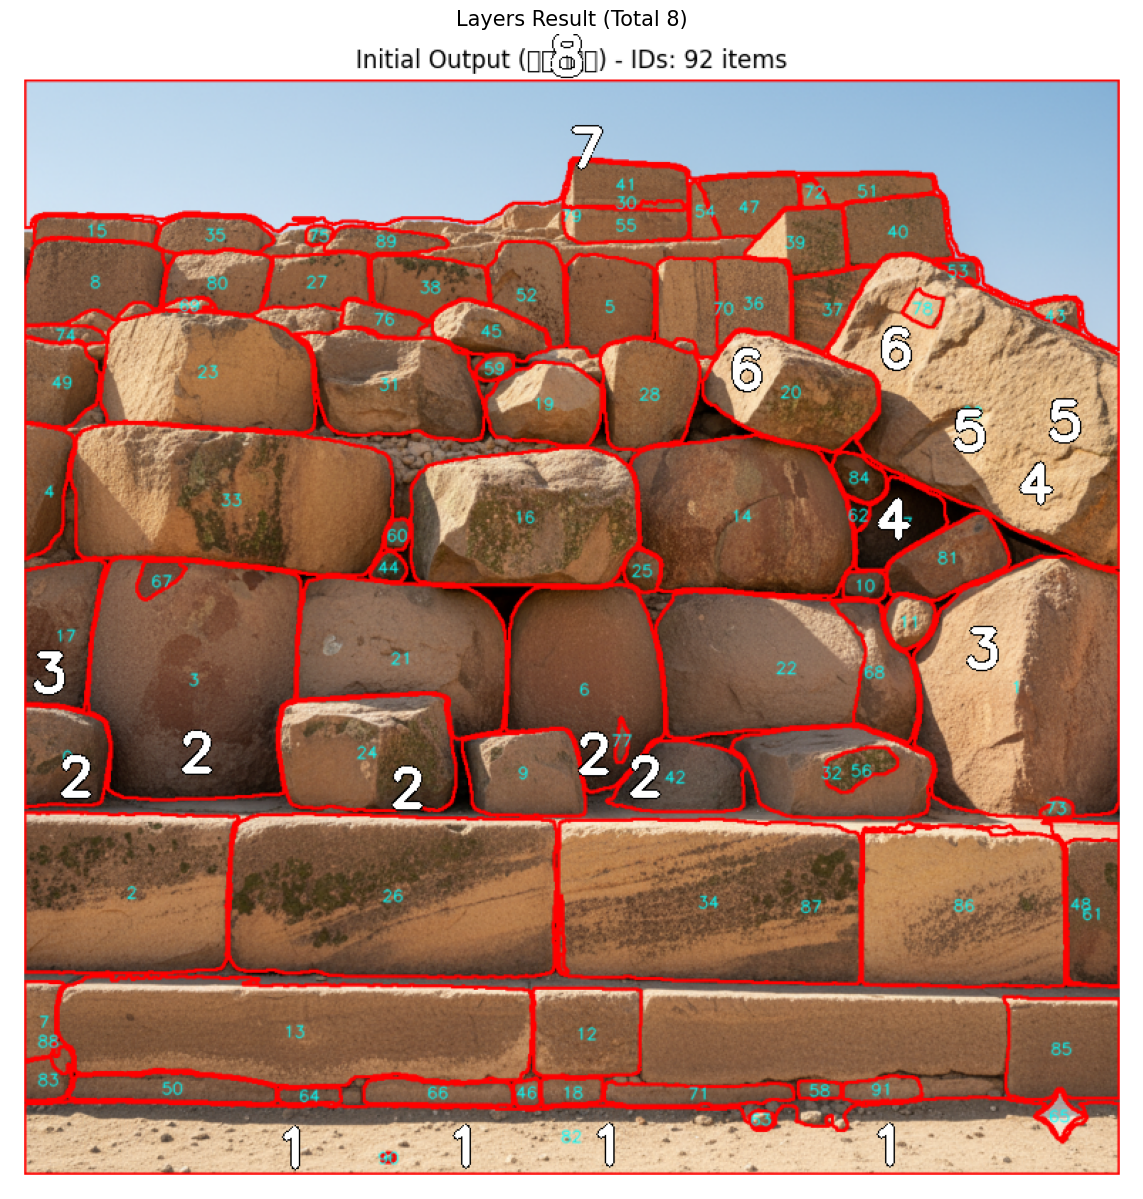

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def analyze_layers_gap_method_v3():
    # --- 0. パス設定 ---
    base_dir = os.getcwd()
    target_img_path = os.path.join(base_dir, "images", "output1.png")
    
    print(f"解析対象: {target_img_path}")

    # --- 1. 画像読み込み ---
    img_bgr = cv2.imread(target_img_path)
    if img_bgr is None:
        print("❌ 画像が見つかりません。")
        return

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_result = img_rgb.copy()
    h, w = img_bgr.shape[:2] # 高さ、幅を取得

    # --- 2. 線の抽出（青・赤 両対応） ---
    # 青マスク
    lower_blue = np.array([100, 0, 0])     # 範囲を広げました
    upper_blue = np.array([255, 150, 150])
    mask_blue = cv2.inRange(img_bgr, lower_blue, upper_blue)

    # 赤マスク
    lower_red = np.array([0, 0, 100])      # 範囲を広げました
    upper_red = np.array([150, 150, 255])
    mask_red = cv2.inRange(img_bgr, lower_red, upper_red)

    # 合体
    mask_lines = mask_blue + mask_red

    # 【重要修正 1】画像の周りを強制的に線で囲む
    # これで「画像の端っこ」から漏れるのを防ぎます
    cv2.rectangle(mask_lines, (0, 0), (w-1, h-1), 255, thickness=5)

    # 【重要修正 2】線を太くして隙間を埋める (Dilation)
    # 5x5のカーネルを使って、線をガッツリ太くします
    kernel = np.ones((5, 5), np.uint8)
    mask_lines_dilated = cv2.dilate(mask_lines, kernel, iterations=2)

    # デバッグ用に、認識した「線」の状態を確認したい場合はコメントアウトを外してください
    # plt.imshow(mask_lines_dilated, cmap='gray'); plt.show()

    # --- 3. 石の抽出（反転） ---
    # 線以外の部分を白くする
    mask_stones = cv2.bitwise_not(mask_lines_dilated)

    # 輪郭検出
    contours, _ = cv2.findContours(mask_stones, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"検出された領域の数（修正後）: {len(contours)}")

    # --- 4. 石データの抽出 ---
    stones = []
    heights = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        
        # 小さすぎるゴミは無視
        if area < 300: 
            continue
        
        # 画像全体（空など）を除外するための閾値
        # 30%以上を占めるものは背景とみなす
        if area > (h * w * 0.3):
            continue

        x, y, bounding_w, bounding_h = cv2.boundingRect(cnt)
        heights.append(bounding_h)

        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            
            stones.append({
                "cx": cx, "cy": cy, "h": bounding_h, "m": 0, "done": False
            })

    if not stones:
        print("❌ まだ石が分離できていません。線の膨張(iterations)をもっと増やす必要があるかもしれません。")
        # マスクの状態を表示してデバッグ
        plt.figure(figsize=(10,10))
        plt.title("Debug: White areas are recognized as stones")
        plt.imshow(mask_stones, cmap='gray')
        plt.show()
        return

    # 平均高さ計算
    avg_height = np.mean(heights)
    print(f"石の平均高さ: {avg_height:.1f} pixel")

    # --- 5. レイヤー（m）割り当て ---
    stones.sort(key=lambda s: s["cy"], reverse=True)
    current_m = 1
    tolerance = avg_height * 0.6 # 少し緩めに

    while True:
        remaining = [s for s in stones if not s["done"]]
        if not remaining:
            break
        
        base_y = remaining[0]["cy"]
        
        processed_count = 0
        for stone in stones:
            if not stone["done"]:
                # 高さ判定
                if abs(stone["cy"] - base_y) < tolerance:
                    stone["m"] = current_m
                    stone["done"] = True
                    processed_count += 1
        
        if processed_count == 0:
             remaining[0]["done"] = True
             
        current_m += 1

    # --- 6. 結果描画 ---
    for stone in stones:
        cx, cy = stone["cx"], stone["cy"]
        m_val = stone["m"]
        text = str(m_val)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        # 文字サイズ調整
        cv2.putText(img_result, text, (cx - 15, cy + 10), font, 1.2, (0, 0, 0), 6)
        cv2.putText(img_result, text, (cx - 15, cy + 10), font, 1.2, (255, 255, 255), 3)

    plt.figure(figsize=(15, 15))
    plt.imshow(img_result)
    plt.axis('off')
    plt.title(f"Layers Result (Total {current_m-1})", fontsize=15)
    plt.show()

# 実行
analyze_layers_gap_method_v3()